In [1]:
# imports
import numpy                   as     np
import pandas                  as     pd
import matplotlib.pyplot       as     plt

from sklearn.model_selection   import train_test_split
from sklearn.pipeline          import make_pipeline
from sklearn.metrics           import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing     import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble          import RandomForestClassifier
from sklearn.naive_bayes       import MultinomialNB
from sklearn.metrics           import roc_curve, auc
from sklearn.model_selection   import StratifiedKFold

from tpot.builtins             import StackingEstimator
from scipy                     import interp
# end of imports

In [2]:
# configuration
np.random.seed(1407)
%matplotlib inline
# end of configuration

In [3]:
# data loading
all_features = pd.read_csv('all_train.csv')
has_parkinson = all_features['has_parkinson']
all_features.drop(['has_parkinson'], axis=1, inplace=True)
all_features.drop(['id'], axis=1, inplace=True)

all_features_train, all_features_test, has_parkinson_train, has_parkinson_test \
    = train_test_split(all_features, has_parkinson,
                       train_size=0.8, test_size=0.2)
# end of data loading

In [4]:
# pipeline creation
exported_pipeline = make_pipeline(
    SelectKBest(k=300),
    MinMaxScaler(),
    StackingEstimator(
        estimator=RandomForestClassifier(bootstrap=False, criterion='entropy',
                                         max_features=0.8, min_samples_leaf=18,
                                         min_samples_split=15, n_estimators=100)
    ),
    PolynomialFeatures(degree=2, include_bias=False),
    MultinomialNB()
)
# end of pipeline creation

In [5]:
# train and test for Parkinson’s
exported_pipeline.fit(all_features_train, has_parkinson_train)
results = exported_pipeline.predict(all_features_test)
print(accuracy_score(results, has_parkinson_test))
# end train and test for Parkinson’s

/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 243  871 1368 2268] are constant.
  UserWarning)
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.769230769231


/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 243  871 1368 2268] are constant.
  UserWarning)
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 243  871 1368 2268] are constant.
  UserWarning)
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 243  871 1368 2268] are constant.
  UserWarning)
/home/ankitpati/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate

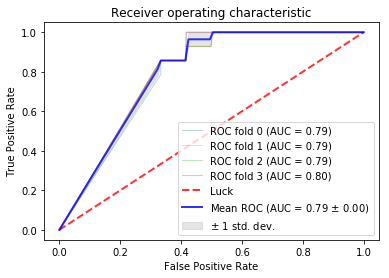

In [6]:
# ROC curve plotting
cv = StratifiedKFold(n_splits=4)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(all_features, has_parkinson):
    probas_ = exported_pipeline.fit(all_features_train, has_parkinson_train) \
                               .predict_proba(all_features_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(has_parkinson_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()
# end of ROC curve plotting

In [7]:
# train and test for Essential Tremor
all_features_et = pd.read_csv('all_et.csv')
has_parkinson_et = all_features_et['has_parkinson']
all_features_et.drop(['has_parkinson'], axis=1, inplace=True)
all_features_et.drop(['id'], axis=1, inplace=True)

results = exported_pipeline.predict(all_features_et)
print(results)
print(accuracy_score(results, has_parkinson_et))
# end of train and test for Essential Tremor

[False  True False  True  True  True False  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True]
0.153846153846
